In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(False)

local
local


[0.]
[1.91513472e-17]
[0.]
SolutionCollectionLattice(comment='', xyt=array([[[-0.075     ,  0.32039864,  0.        ],
        [ 0.075     , -0.32039864,  3.14159265]]]), h=array([[2.        , 2.        , 1.57079633]]), periodic=True)


<Axes: >

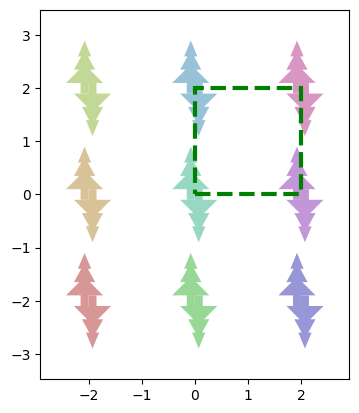

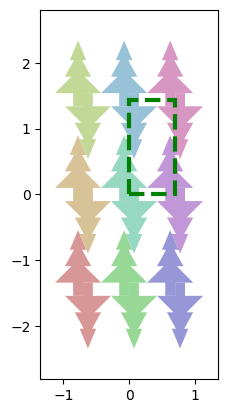

In [ ]:
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
sol = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[2.,2.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
X=1/kgs.just_over_one
sol.xyt[0,:,:2]*=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
sol.xyt[0,:,:2]/=X
sol.xyt[0,:,:2]/=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
print(sol)
pack_dimer.snap_cell(sol, skip_assert=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)

In [ ]:
import tqdm
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/20000), dtype=kgs.dtype_cp)
rot_cell_vals = cp.array(np.arange(np.pi/4, np.pi/2*kgs.just_over_one, np.pi/400), dtype=kgs.dtype_cp)
res_area = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
res_aspect_ratio = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
sol_base = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[3.,3.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()
for j, rot_cell in enumerate(tqdm.tqdm(rot_cell_vals)):
    sol = copy.deepcopy(sol_base)
    sol.h[:,2] = rot_cell        
    pack_dimer.snap_cell(sol, skip_assert=True)
    res_area[:,j] = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
    res_aspect_ratio[:,j] = (sol.h[:,0]/(sol.h[:,1]*np.sin(sol.h[:,2]))).get()   
        


100%|██████████| 101/101 [01:22<00:00,  1.22it/s]


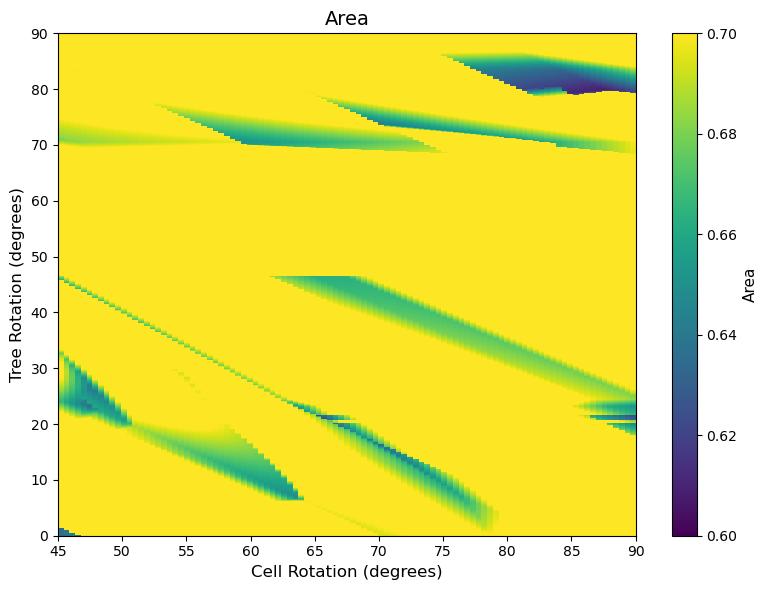

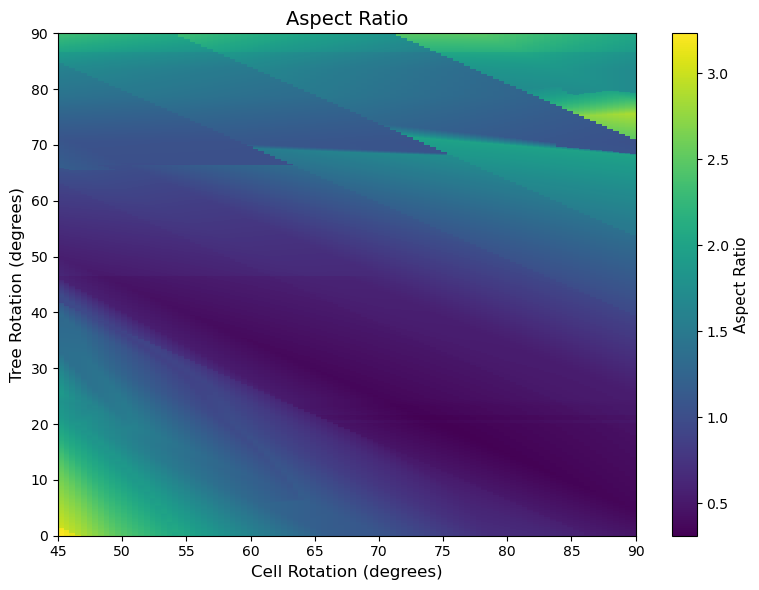

<Axes: title={'center': 'Aspect Ratio'}, xlabel='Cell Rotation (degrees)', ylabel='Tree Rotation (degrees)'>

In [ ]:
import matplotlib.pyplot as plt
def plot_rotation_heatmap(data, rot_tree_vals, rot_cell_vals, title, cbar_label, clim=None):
    """Plot a heatmap of rotation analysis results."""
    # Convert radians to degrees for axis labels
    rot_tree_degrees = np.degrees(rot_tree_vals.get())
    rot_cell_degrees = np.degrees(rot_cell_vals.get())
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='bone',
                   extent=[rot_cell_degrees[0], rot_cell_degrees[-1], 
                          rot_tree_degrees[0], rot_tree_degrees[-1]], interpolation='none')
    ax.set_xlabel('Cell Rotation (degrees)', fontsize=12)
    ax.set_ylabel('Tree Rotation (degrees)', fontsize=12)
    ax.set_title(title, fontsize=14)
    if clim is not None:
        im.set_clim(*clim)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)
    
    plt.tight_layout()    
    plt.show()

    return ax

# Create two separate figures
ax = plot_rotation_heatmap(res_area, rot_tree_vals, rot_cell_vals, 
                      'Area', 'Area', clim=(0.6,0.8))


plot_rotation_heatmap(res_aspect_ratio, rot_tree_vals, rot_cell_vals, 
                      'Aspect Ratio', 'Aspect Ratio')

In [ ]:
import tqdm
import pack_ga
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
def relax_sol(sol, legalize=True):
    relaxer = pack_ga.GA().fine_relaxers[0]
    relaxer.cost.costs.pop(1)
    relaxer.plot_interval = None
    relaxer.n_iterations//=2
    #pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
    #plt.pause(3)
    sol = relaxer.run_simulation(sol)
    if legalize:
        for _ in range(10):
            print(_)
            relaxer.cost.costs[0].scaling *= 0.5
            sol = relaxer.run_simulation(sol)
    return sol
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/2000), dtype=kgs.dtype_cp)
sol_base = kgs.SolutionCollectionLatticeRectangle(xyt=dimer[None], h=cp.array([[3.,3.]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()       
sol = copy.deepcopy(sol_base)
pack_dimer.snap_cell(sol, skip_assert=False)
res_area2 = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
res_aspect_ratio2 = (sol.h[:,0]/sol.h[:,1]).get()   
#pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
sol_r = relax_sol(copy.deepcopy(sol))
res_area3 = pack_cost.AreaCost().compute_cost_allocate(sol_r)[0].get()
res_aspect_ratio3 = (sol_r.h[:,0]/sol_r.h[:,1]).get()


0
1
2
3
4
5
6
7
8
9


(1001,)


['20.1600',
 '21.6000',
 '23.2200',
 '25.1100',
 '68.4900',
 '79.5600',
 '0.0000rel',
 '9.9900rel',
 '20.9700rel',
 '21.9600rel',
 '29.9700rel',
 '68.4900rel',
 '84.9600rel']

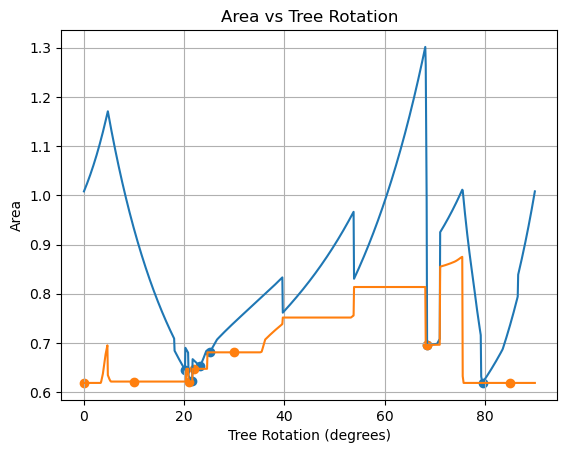

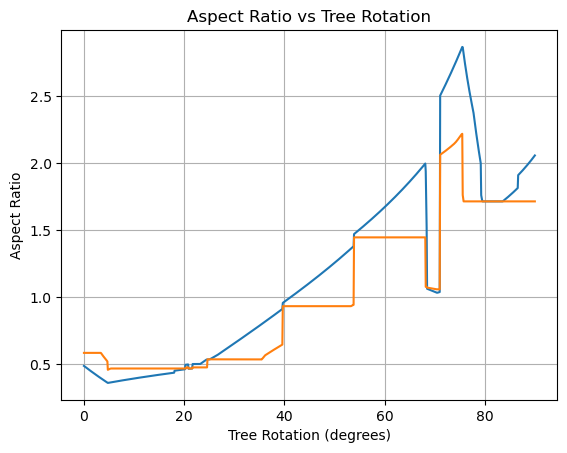

In [47]:
import mplcursors

fig1, ax1 = plt.subplots()
line1 = ax1.plot(np.degrees(rot_tree_vals.get()), res_area2)
ax1.plot(np.degrees(rot_tree_vals.get()), res_area3)
ax1.grid(True)
ax1.set_xlabel('Tree Rotation (degrees)')
ax1.set_ylabel('Area')
ax1.set_title('Area vs Tree Rotation')
mplcursors.cursor(line1, hover=True)

fig2, ax2 = plt.subplots()
line2 = ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio2)
ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio3)
ax2.grid(True)
ax2.set_xlabel('Tree Rotation (degrees)')
ax2.set_ylabel('Aspect Ratio')
ax2.set_title('Aspect Ratio vs Tree Rotation')
mplcursors.cursor(line2, hover=True)

from scipy.signal import find_peaks
a,b = find_peaks(-res_area2, height=-1000)
b=-b['peak_heights']
sel = b<0.7
a=a[sel]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area2[a])
solx = copy.deepcopy(sol)
solx.xyt = solx.xyt[a]
solx.h = solx.h[a]
names = [f'{np.degrees(r.get()):.4f}' for r in rads_min]

print(res_area3.shape)
deg_vals = np.array([0., 10., 21., 22., 30., 68.5, 85.])
rad_vals = np.radians(deg_vals)
# find indices closest to rad_vals
a = [np.argmin(np.abs(rot_tree_vals.get() - rv)) for rv in rad_vals]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area3[a])
solx.xyt = cp.concatenate((solx.xyt,sol_r.xyt[a]))
solx.h = cp.concatenate((solx.h,sol_r.h[a]))
names = names+[f'{np.degrees(r.get()):.4f}rel' for r in rads_min]
names

<Figure size 600x600 with 0 Axes>

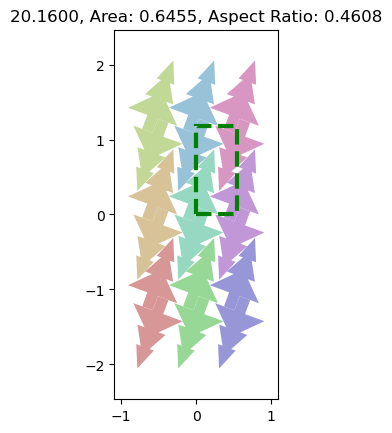

<Figure size 600x600 with 0 Axes>

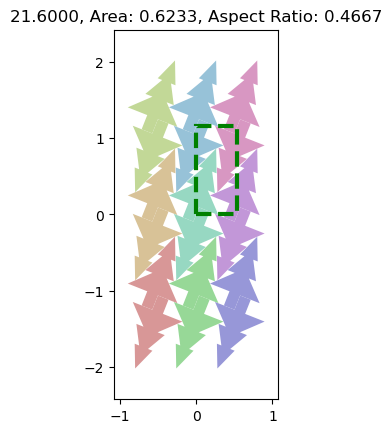

<Figure size 600x600 with 0 Axes>

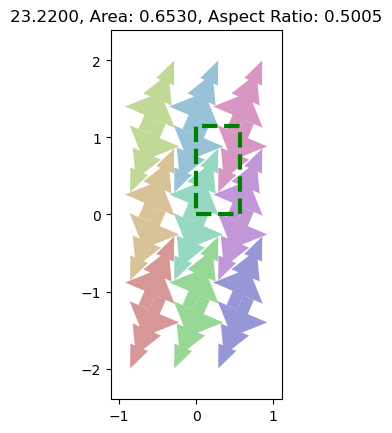

<Figure size 600x600 with 0 Axes>

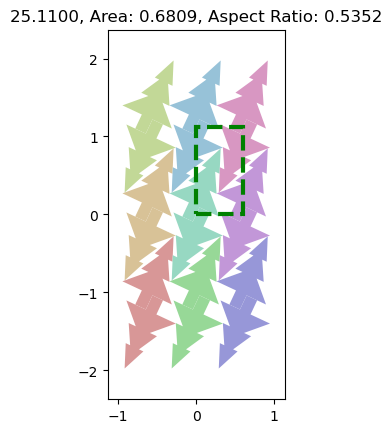

<Figure size 600x600 with 0 Axes>

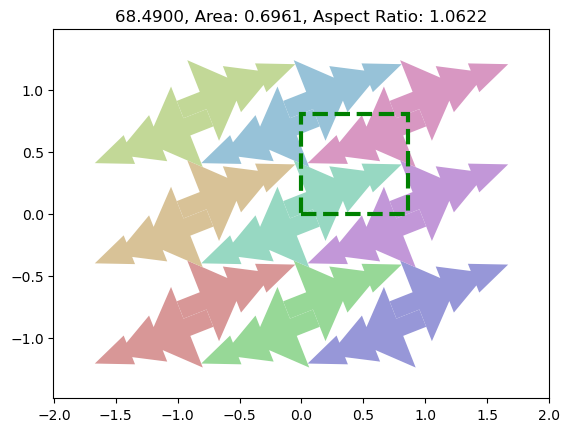

<Figure size 600x600 with 0 Axes>

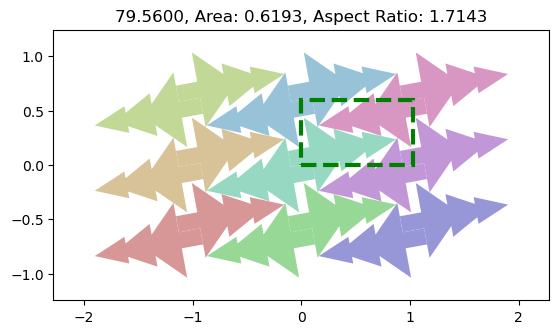

<Figure size 600x600 with 0 Axes>

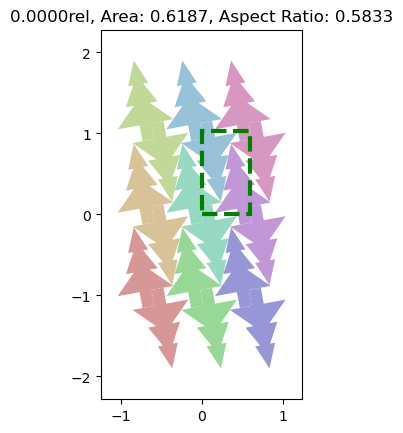

<Figure size 600x600 with 0 Axes>

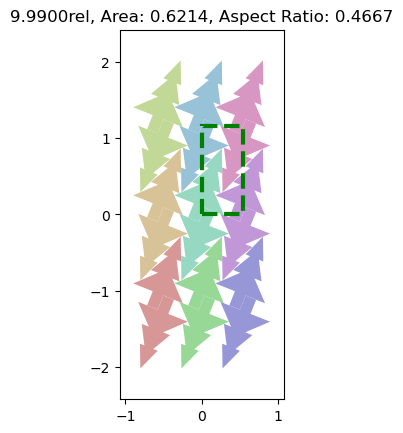

<Figure size 600x600 with 0 Axes>

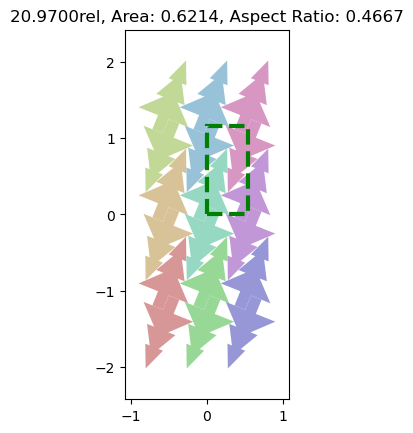

<Figure size 600x600 with 0 Axes>

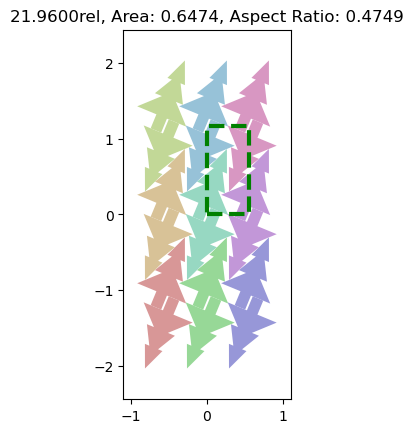

<Figure size 600x600 with 0 Axes>

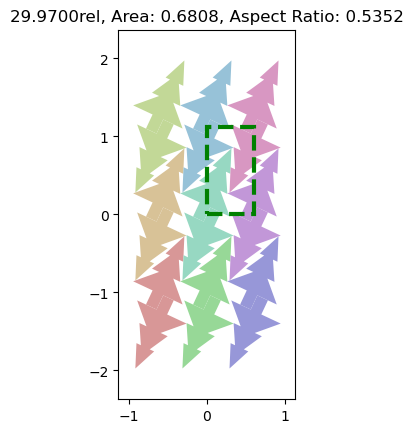

<Figure size 600x600 with 0 Axes>

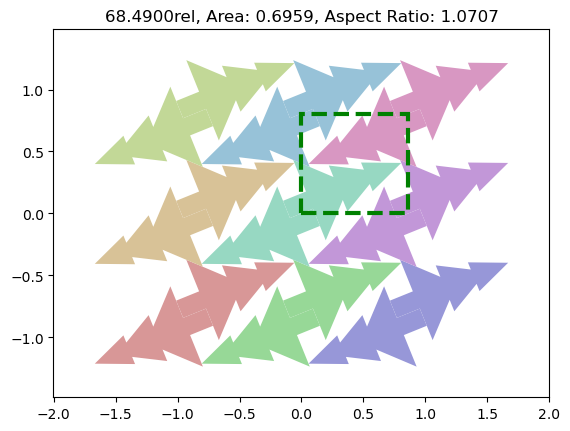

<Figure size 600x600 with 0 Axes>

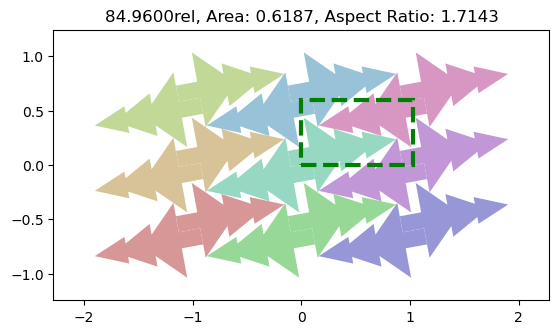

In [57]:
best_trees_list = []
for i in range(solx.N_solutions):
    plt.figure(figsize=(6,6))
    this_sol = copy.deepcopy(solx)
    this_sol.xyt = this_sol.xyt[i:i+1]
    this_sol.h = this_sol.h[i:i+1]
    pack_vis_sol.pack_vis_sol(this_sol)
    plt.title(f'{names[i]}, Area: {pack_cost.AreaCost().compute_cost_allocate(this_sol)[0].get()[0]:.4f}, Aspect Ratio: {this_sol.h[0,0]/this_sol.h[0,1]:.4f}')
    plt.show()
    # sol = copy.deepcopy(sol_base)
    # sol.rotate(cp.array([rot_tree]))
    # sol.h[0,2] = rot_cell        
    # pack_dimer.snap_cell(sol, skip_assert=False)
    # area = sol.compute_cost_single_ref(sol.h[0])[0].get()
    # aspect_ratio = sol.h[0,0]/(sol.h[0,1]*np.sin(sol.h[0,2]))
    # pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
    # plt.title(f"Tree Rot: {np.degrees(rot_tree):.2f} deg, Area: {area:.4f}, Aspect Ratio: {aspect_ratio:.4f}")
    best_trees_list.append(pack_dimer.try_tilings(this_sol))

In [55]:
import pack_io
importlib.reload(pack_io)
import pandas as pd
[sol_list_ref, scores] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.97.csv'))
#for s in sol_list_ref:
#    s.rotate(-np.pi/2)

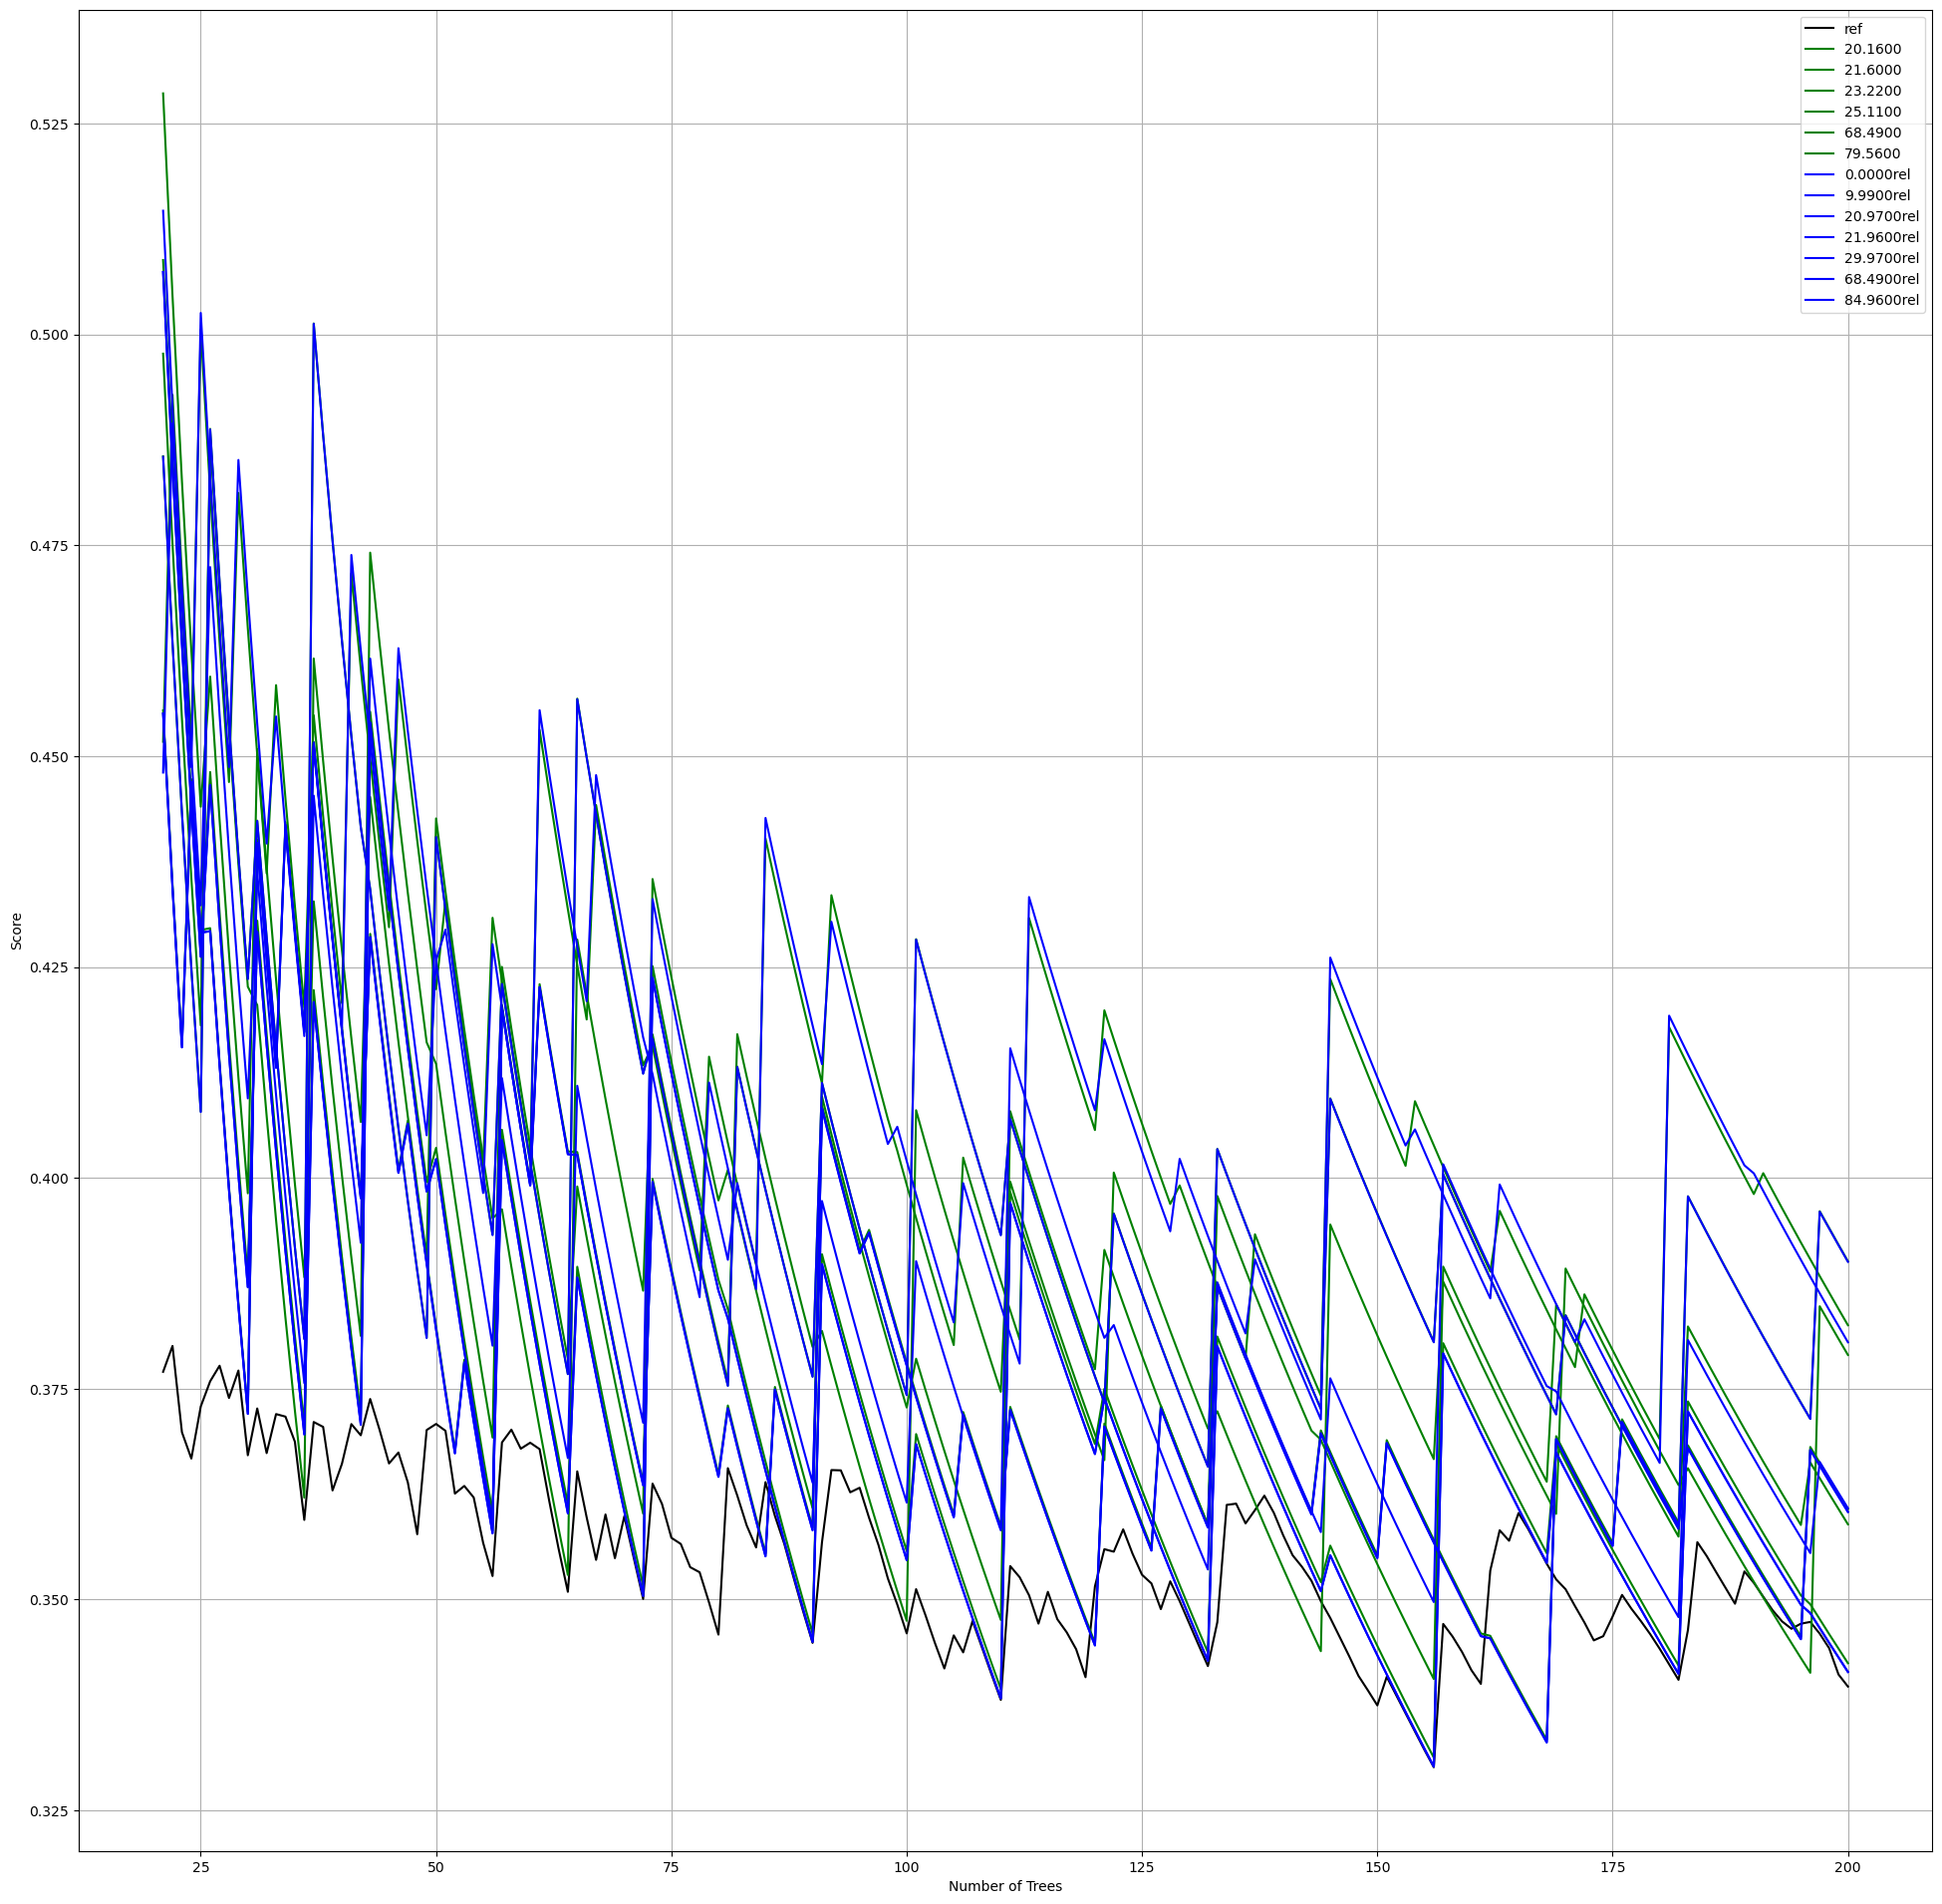

In [60]:
plt.figure(figsize=(24,24))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], scores[N:], 'k')
lines.extend(line)
for i,b in enumerate(best_trees_list):
    this_vals = b[0]**2/N_trees
    vals_res = np.minimum(vals_res, this_vals)
    if 'rel' in names[i]:        
        line = plt.plot(N_trees[N:], this_vals[N:], 'b')
    else:
        line = plt.plot(N_trees[N:], this_vals[N:], 'g')
    lines.extend(line)
plt.grid(True)
plt.legend(['ref']+names)
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)

In [61]:
overall_best = []
for i_tree in range(200):
    best_id = np.argmin([b[0][i_tree] for b in best_trees_list])
    best_sol = best_trees_list[best_id][1][i_tree]
    overall_best.append(best_sol)

In [62]:
import pack_io
import boolean_line_search
import pack_metric
importlib.reload(boolean_line_search)
importlib.reload(pack_io)
importlib.reload(pack_metric)
#x=pack_io.solution_list_to_dataframe(overall_best)
#x
#x.to_csv(kgs.temp_dir + 'submission.csv', index=False)

<module 'pack_metric' from '/mnt/d/packing/code/analysis/../core/pack_metric.py'>

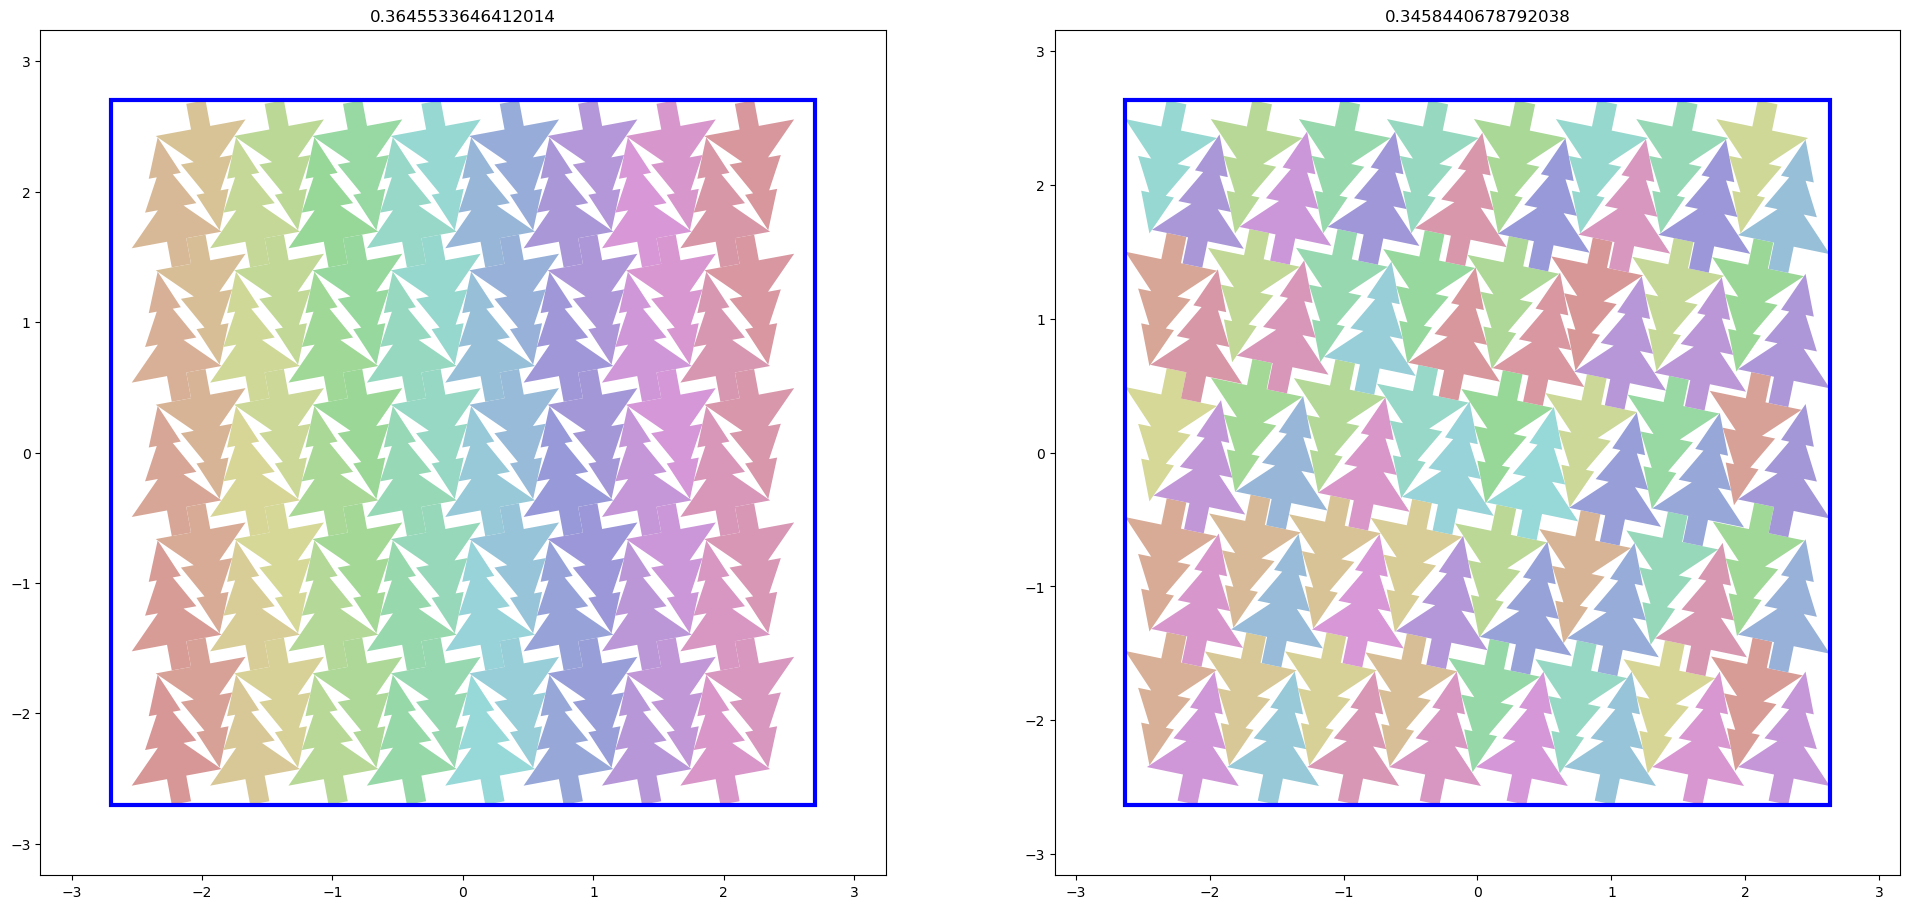

In [65]:
for N in [80]:
    _,ax = plt.subplots(1,2,figsize=(24,12))
    pack_vis_sol.pack_vis_sol(overall_best[N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(overall_best[N-1].h[0,0]**2/overall_best[N-1].N_trees)
    sol2 = copy.deepcopy(sol_list_ref[N-1])
    sol2.rotate(cp.array([-np.pi/2]))
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(sol_list_ref[N-1].h[0,0]**2/overall_best[N-1].N_trees)

local
stop final relax at some point
local
False


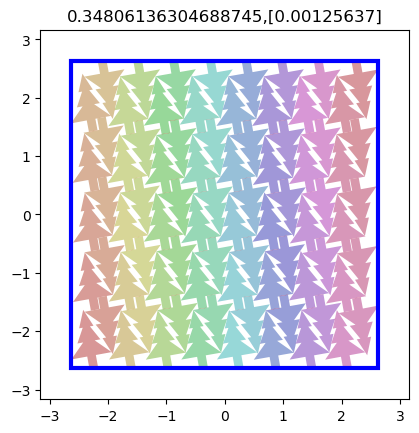

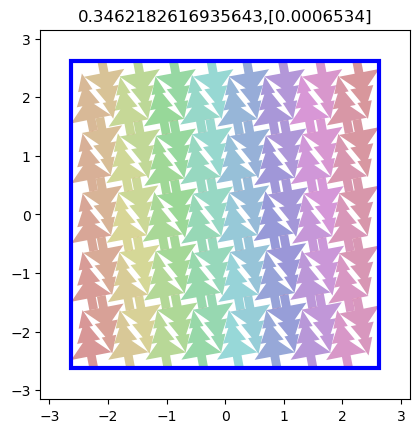

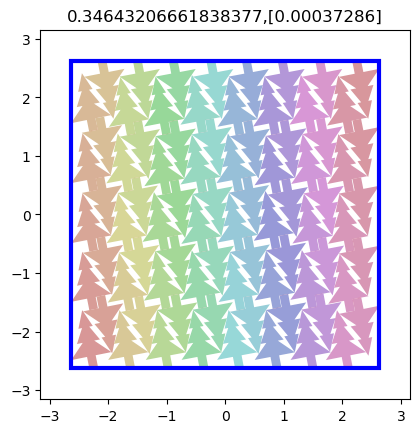

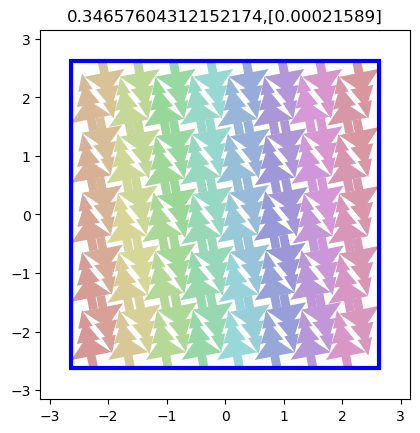

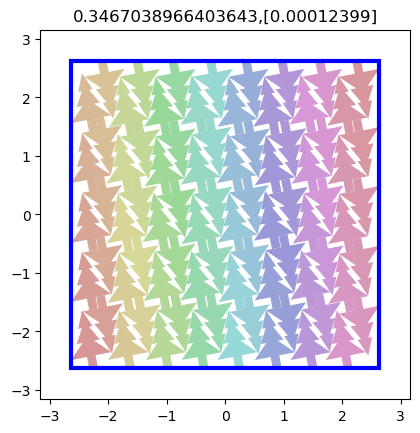

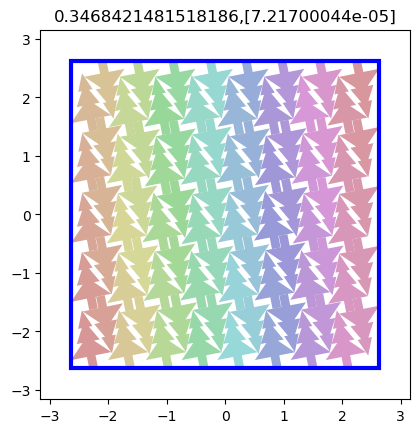

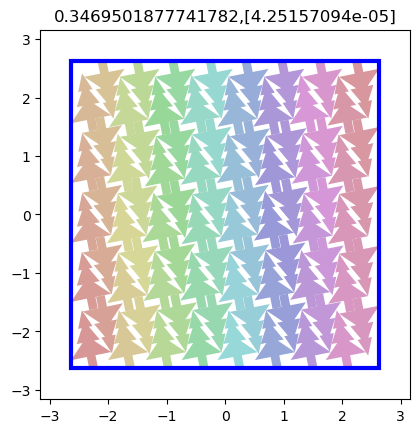

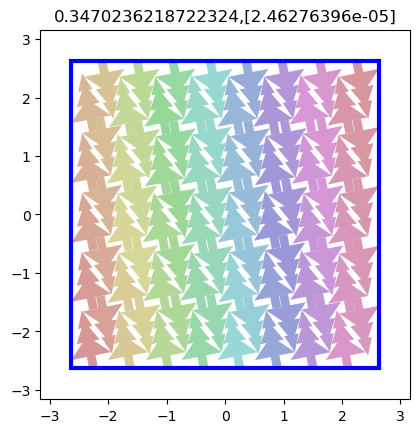

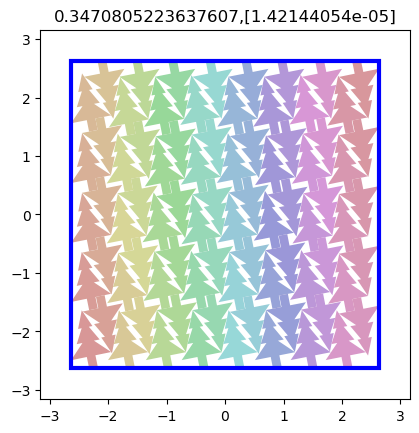

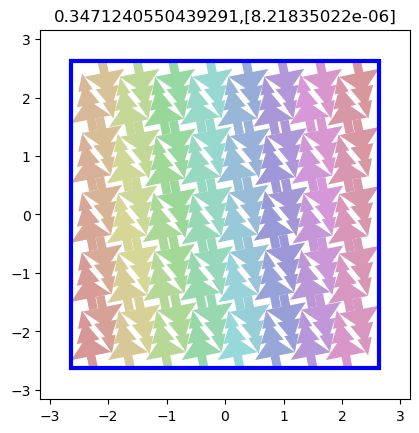

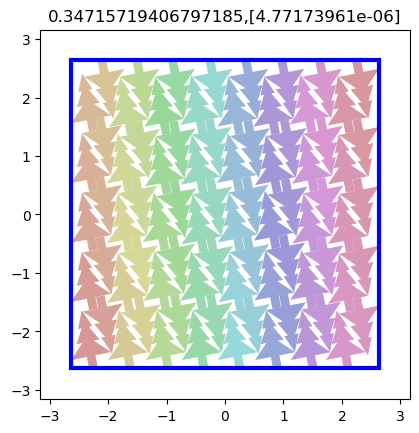

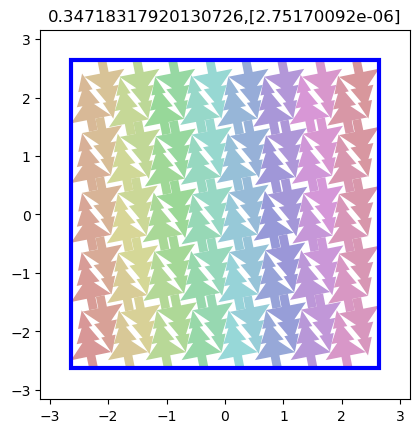

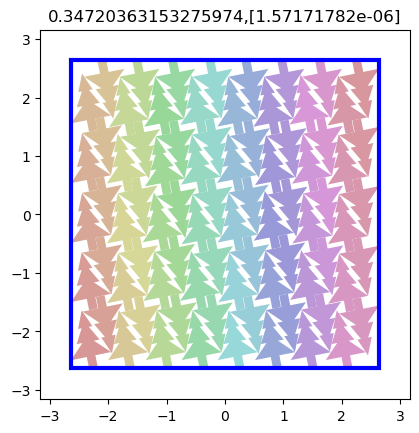

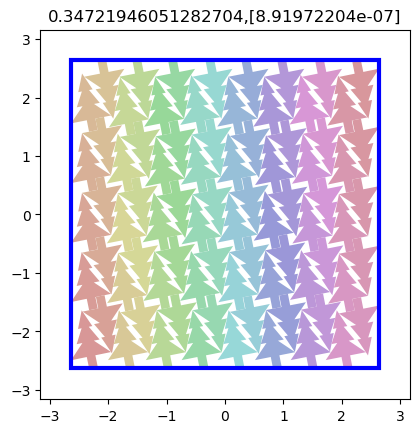

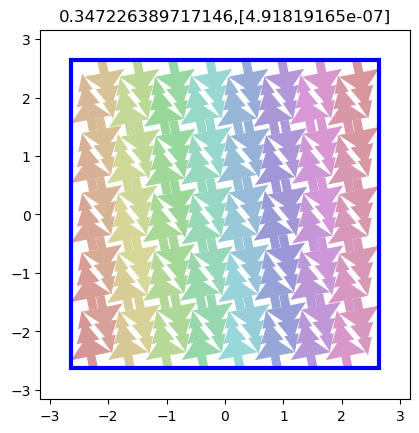

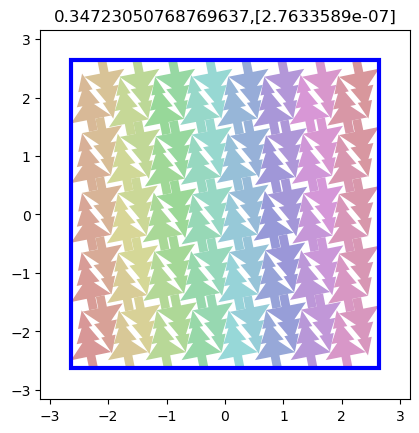

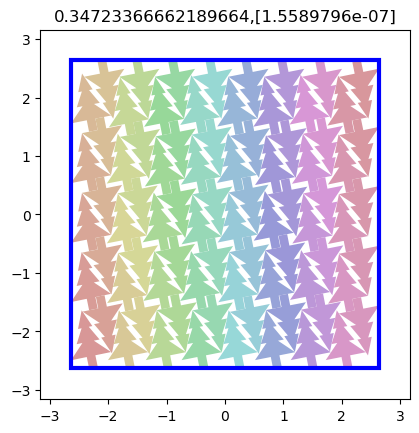

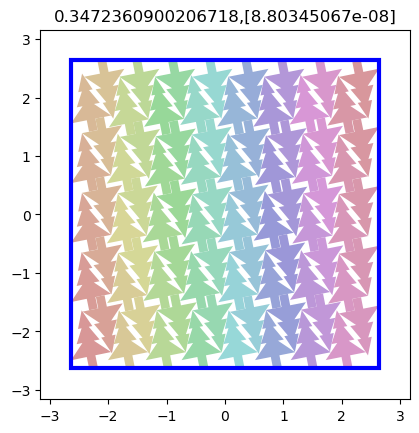

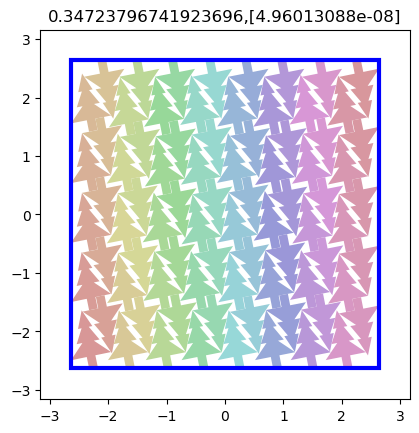

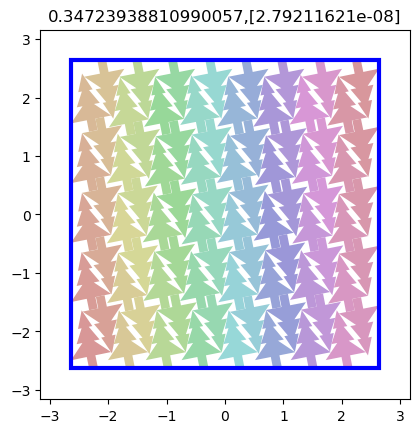

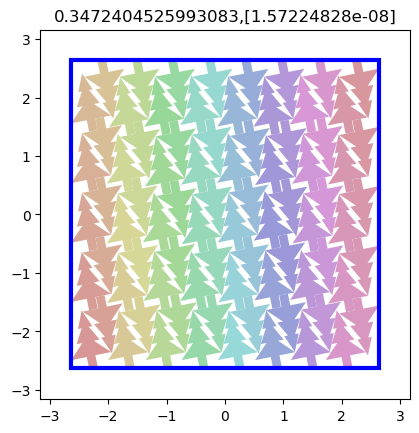

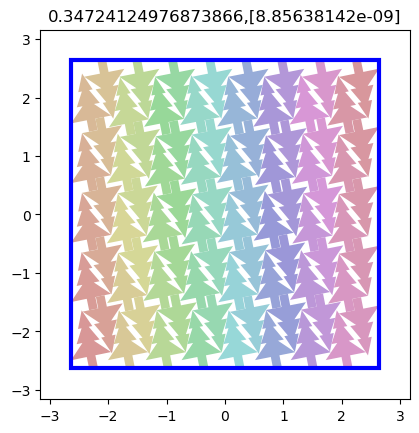

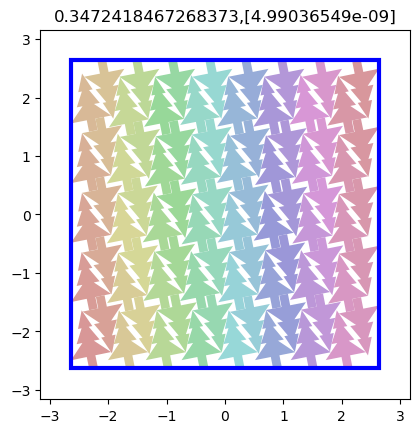

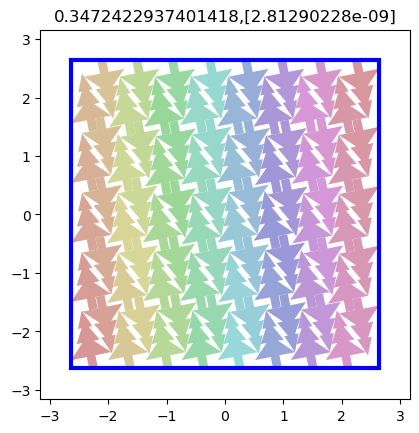

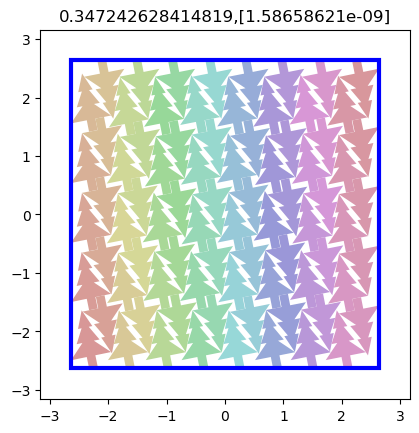

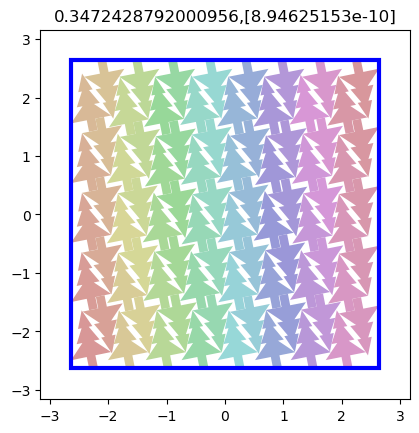

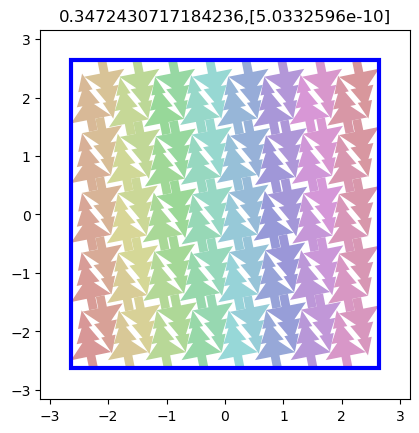

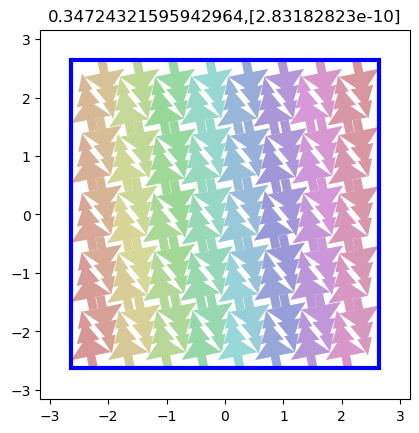

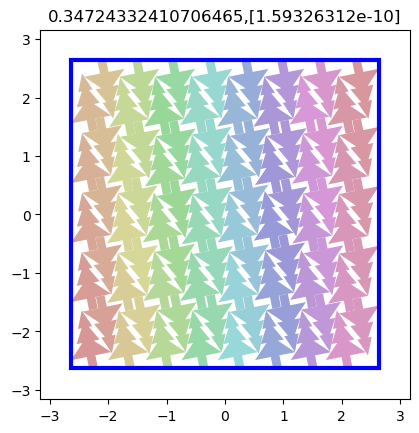

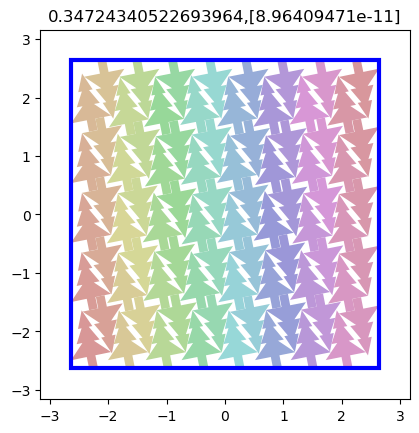

In [67]:
import pack_ga
import pack_cuda
import pack_dynamics
importlib.reload(kgs)
importlib.reload(pack_cuda)
importlib.reload(pack_ga)
importlib.reload(pack_dynamics)
kgs.debugging_mode = 2
kgs.set_float32(False)
print(pack_cuda._initialized)
relaxer = pack_ga.GA().fine_relaxers[0]
relaxer.plot_interval = None
relaxer.dt/=4
sol = copy.deepcopy(overall_best[N-1])
xyt = sol.xyt.astype(kgs.dtype_cp)
h = sol.h.astype(kgs.dtype_cp)
sol = kgs.SolutionCollectionSquare(xyt=xyt, h=h)
#pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
for _ in range(30):
    sol = relaxer.run_simulation(sol)
    pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
    sol.snap()
    plt.title(f'{sol.h[0,0]**2/sol.N_trees},{pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0].get()}')
    relaxer.cost.costs[0].scaling *= 0.75
    plt.pause(0.001)


In [68]:
import pack_io
import boolean_line_search
import pack_metric
importlib.reload(boolean_line_search)
importlib.reload(pack_io)
importlib.reload(pack_metric)
xx=pack_io.solution_list_to_dataframe([sol])
xx

Score of generated dataframe: 0.34724707379889347


id                     x                     y                  deg
0    080_0  s-2.2924938551254885   s-2.424318901968967  s11.617223457214628
1    080_1  s-2.2924937059211565  s-1.4280909117329963  s11.617190204713095
2    080_2  s-2.0960192982846757  s-1.5918827421012665  s191.61719023400718
3    080_3   s-2.291985843427845  s-0.4160525571806756   s11.19706602137936
4    080_4  s-2.1043899593753657  s-0.5833539701172908  s191.61713253848865
..     ...                   ...                   ...                  ...
75  080_75    s2.104389812353385    s0.583352570437917   s11.61711556424933
76  080_76   s2.2919858774082154  s0.41605133018963636  s191.19709464664888
77  080_77   s2.0960198400724694   s1.5918816324126215  s11.617173259376427
78  080_78   s2.2924936850481767   s1.4280896381626538   s191.6171732378297
79  080_79    s2.292493827268167   s2.4243189272890544  s191.61720664783658

[80 rows x 4 columns]

In [ ]:
kgs.dtype_cp

numpy.float32

In [ ]:
relaxer.cost.costs[0]

AreaCost(comment='', scaling=0.01)